# The art of using t-SNE for single-cell transcriptomics
## UMI-based datasets

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
from scipy import sparse

# import tsne
import sys; sys.path.append('/Users/dsmolyak/Downloads/FIt-SNE-master')
from fast_tsne import fast_tsne

# import my feature selection function and other stuff
import rnaseqTools

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

In [2]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist

def embedding_quality(X, Z, classes, knn=10, knn_classes=10, subsetsize=1000):
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn
    
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn, mnn_global, rho)

## Harris et al., PLoS Bio 2018

The data are taken from:

* `expression.tsv.gz` is from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE99888
* `analysis_results.tsv` is from https://figshare.com/articles/Transcriptomic_analysis_of_CA1_inhibitory_interneurons/6198656
* `colormap.txt` generated in Matlab as in https://github.com/cortex-lab/Transcriptomics/blob/master/GeneSet.m#L839

     ```
     cm0 = hsv(ceil(49*1.2));                // 49 is the number of clusters
     Yellowness = cm0(:,1)+cm0(:,2);
     Divisor = 1 + max(Yellowness - .7, 0);
     cm = bsxfun(@rdivide, cm0, Divisor);    // then save or copy-paste cm into file```

In [3]:
%%time
# GSE99888_gene_expression.tab
# expression.tsv
counts, genes, cells = rnaseqTools.sparseload('data/expression.tsv.gz', sep='\t', 
                                              droplastcolumns=1)

data = pd.read_csv('data/analysis_results.tsv', sep='\t')
clusterNames, clusters = np.unique(data.values[0,1:-1], return_inverse=True)

data = pd.read_csv('data/harris-colormap.txt', sep='\s+', header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = ['Sst.No', 'Sst.Npy.C', 'Sst.Npy.Z', 'Sst.Npy.S', 'Sst.Npy.M',
                'Sst.Pnoc.Calb1.I', 'Sst.Pnoc.Calb1.P', 'Sst.Pnoc.P', 'Sst.Erbb4.R',
                'Sst.Erbb4.C', 'Sst.Erbb4.T', 'Pvalb.Tac1.N', 'Pvalb.Tac1.Ss',
                'Pvalb.Tac1.Sy', 'Pvalb.Tac1.A', 'Pvalb.C1ql1.P', 'Pvalb.C1ql1.C',
                'Pvalb.C1ql1.N', 'Cacna2d1.Lhx6.R', 'Cacna2d1.Lhx6.V', 'Cacna2d1.Ndnf.N',
                'Cacna2d1.Ndnf.R', 'Cacna2d1.Ndnf.C', 'Calb2.Cry', 'Sst.Cry', 'Ntng1.S',
                'Ntng1.R', 'Ntng1.C', 'Cck.Sema', 'Cck.Lmo1.N', 'Cck.Calca', 'Cck.Lmo1.Vip.F',
                'Cck.Lmo1.Vip.C', 'Cck.Lmo1.Vip.T', 'Cck.Ly', 'Cck.Cxcl14.Calb1.Tn',
                'Cck.Cxcl14.Calb1.I', 'Cck.Cxcl14.S', 'Cck.Cxcl14.Calb1.K',
                'Cck.Cxcl14.Calb1.Ta', 'Cck.Cxcl14.V', 'Vip.Crh.P', 'Vip.Crh.C1', 'Calb2.Vip.G',
                'Calb2.Vip.I', 'Calb2.Vip.Nos1', 'Calb2.Cntnap5a.R', 'Calb2.Cntnap5a.V',
                'Calb2.Cntnap5a.I']

reorder = np.zeros(clusterNames.size) * np.nan
for i,c in enumerate(clusterNames):
    for j,k in enumerate(clusterOrder):
        if c[:len(k)]==k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

harris = {'counts': counts, 'genes': genes, 'clusters': clusters, 
          'clusterColors': clusterColors, 'clusterNames': clusterNames}

pickle.dump(harris, open('data/harris.pickle', "wb"))

............................ done
CPU times: user 15.4 s, sys: 2.42 s, total: 17.8 s
Wall time: 18.5 s


In [4]:
harris = pickle.load(open('data/harris.pickle', "rb"))
print(harris['counts'].shape)

(3663, 27998)


# Distance Experiments

In [10]:
total_count = 0
for cluster in np.unique(harris['clusters']):
    curr_count = np.count_nonzero(harris['clusters'] == cluster)
    print(cluster, curr_count)
    total_count += curr_count**2
total_count

0 270
1 86
2 47
3 85
4 106
5 25
6 50
7 51
8 50
9 121
10 101
11 60
12 31
13 72
14 48
15 36
16 118
17 119
18 72
19 66
20 61
21 58
22 49
23 17
24 71
25 74
26 72
27 48
28 67
29 29
30 115
31 57
32 52
33 76
34 83
35 27
36 22
37 27
38 34
39 35
40 69
41 61
42 171
43 85
44 264
45 158
46 93
47 18
48 56


405997

In [31]:
nonzeros = np.sum(harris['counts'] != 0)
nonzeros / (harris['counts'].shape[0] * harris['counts'].shape[1])

0.09359620028239216

In [35]:
%%time
metrics = [0,0.2,0.4,1,2]
inside_dists, outside_dists = {metric: {} for metric in metrics}, {metric: {} for metric in metrics}
for cluster in np.unique(harris['clusters']):
    print(cluster)
    cluster_size = np.count_nonzero(harris['clusters'] == cluster)
    curr_cluster = harris['counts'][harris['clusters'] == cluster]
    random_points = np.random.choice(cluster_size, min(11, cluster_size), replace=False)
    curr_point = curr_cluster[random_points[0]].toarray().flatten()
    in_compare = np.array([curr_cluster[rand].toarray().flatten() for rand in random_points[1:]])
    
    random_points = np.random.choice(harris['counts'].shape[0], 10, replace=False)
    cluster_index = np.nonzero(harris['clusters'] == cluster)[0]
    random_points = [rand for rand in random_points if rand not in cluster_index]
    out_compare = np.array([harris['counts'][rand].toarray().flatten() for rand in random_points])
    for dist_metric in metrics:
        inside_dists[dist_metric][cluster] = [np.linalg.norm(curr_point-other, dist_metric) for other in in_compare]
#         print(dist_metric, inside_dists[dist_metric][cluster])
        
        outside_dists[dist_metric][cluster] = [np.linalg.norm(curr_point-other, dist_metric) for other in out_compare]
#         print(outside_dists[dist_metric][cluster])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
CPU times: user 23 s, sys: 3.34 s, total: 26.4 s
Wall time: 10.1 s


In [49]:
pca_50_counts = X 
metrics = [0,0.2,0.4,1,2]
inside_dists_pca, outside_dists_pca = {metric: {} for metric in metrics}, {metric: {} for metric in metrics}
for cluster in np.unique(harris['clusters']):
    cluster_size = np.count_nonzero(harris['clusters'] == cluster)
    curr_cluster = pca_50_counts[harris['clusters'] == cluster]
    random_points = np.random.choice(cluster_size, min(11, cluster_size), replace=False)
    curr_point = curr_cluster[random_points[0]]
    in_compare = np.array([curr_cluster[rand] for rand in random_points[1:]])
    
    random_points = np.random.choice(pca_50_counts.shape[0], 10, replace=False)
    cluster_index = np.nonzero(harris['clusters'] == cluster)[0]
    random_points = [rand for rand in random_points if rand not in cluster_index]
    out_compare = np.array([pca_50_counts[rand] for rand in random_points])
    for dist_metric in metrics:
        inside_dists_pca[dist_metric][cluster] = [np.linalg.norm(curr_point-other, dist_metric) 
                                                  for other in in_compare]
        outside_dists_pca[dist_metric][cluster] = [np.linalg.norm(curr_point-other, dist_metric) 
                                               for other in out_compare]

In [37]:
tsne_counts = Z_harris
metrics = [0,0.2,0.4,1,2]
inside_dists_tsne, outside_dists_tsne = {metric: {} for metric in metrics}, {metric: {} for metric in metrics}
for cluster in np.unique(harris['clusters']):
    cluster_size = np.count_nonzero(harris['clusters'] == cluster)
    curr_cluster = tsne_counts[harris['clusters'] == cluster]
    random_points = np.random.choice(cluster_size, min(11, cluster_size), replace=False)
    curr_point = curr_cluster[random_points[0]]
    in_compare = np.array([curr_cluster[rand] for rand in random_points[1:]])
    
    random_points = np.random.choice(tsne_counts.shape[0], 10, replace=False)
    cluster_index = np.nonzero(harris['clusters'] == cluster)[0]
    random_points = [rand for rand in random_points if rand not in cluster_index]
    out_compare = np.array([tsne_counts[rand] for rand in random_points])
    for dist_metric in metrics:
        inside_dists_tsne[dist_metric][cluster] = [np.linalg.norm(curr_point-other, dist_metric) 
                                                  for other in in_compare]
        outside_dists_tsne[dist_metric][cluster] = [np.linalg.norm(curr_point-other, dist_metric) 
                                               for other in out_compare]

In [43]:
cluster_dists_df = []
for dist_metric in metrics:
    inside_vals, outside_vals = [], []
    for cluster in np.unique(harris['clusters']):
        cluster_size = np.count_nonzero(harris['clusters'] == cluster)
        inside_cluster_avg = np.mean(inside_dists[dist_metric][cluster])
        inside_vals.append(inside_cluster_avg)
        outside_cluster_avg = np.mean(outside_dists[dist_metric][cluster])
        outside_vals.append(outside_cluster_avg)
        cluster_dists_df.append(['harris', cluster, dist_metric, inside_cluster_avg, outside_cluster_avg, 
                                 outside_cluster_avg/inside_cluster_avg, cluster_size])
    avg_inside, avg_outside = np.mean(inside_vals), np.mean(outside_vals)
    print(dist_metric, avg_inside, avg_outside, avg_outside/avg_inside)
    
cluster_dists_df = pd.DataFrame(cluster_dists_df, columns=['dataset', 'cluster','dist_metric', 'inside_avg', 
                                                           'outside_avg', 'out/in ratio', 'cluster_size'])
cluster_dists_df.head()

0 3499.6408163265305 3683.090192743765 1.0524194870403287
0.2 1.221091342077003e+18 1.3691017821430659e+18 1.1212116038873112
0.4 1205109452.42516 1375588705.486358 1.1414637091412119
1 6197.348979591838 7148.877154195011 1.15353793658169
2 211.20434577422114 278.43853434167886 1.31833714557811


,dataset,cluster,dist_metric,inside_avg,outside_avg,out/in ratio,cluster_size
0,harris,0,0.0,3450.7,4014.6,1.163416,270
1,harris,1,0.0,2987.1,3146.9,1.053497,86
2,harris,2,0.0,3390.0,4016.3,1.184749,47
3,harris,3,0.0,3319.4,3622.0,1.091161,85
4,harris,4,0.0,2871.0,3273.5,1.140195,106


In [44]:
cluster_dists_df.to_csv('/Users/dsmolyak/UMD/CMSC858D/project/harris_dist_metric_cluster_gene.csv')

In [50]:
cluster_dists_pca_df = []
for dist_metric in metrics:
    inside_vals, outside_vals = [], []
    for cluster in np.unique(harris['clusters']):
        cluster_size = np.count_nonzero(harris['clusters'] == cluster)
        inside_cluster_avg = np.mean(inside_dists_pca[dist_metric][cluster])
        inside_vals.append(inside_cluster_avg)
        outside_cluster_avg = np.mean(outside_dists_pca[dist_metric][cluster])
        outside_vals.append(outside_cluster_avg)
        cluster_dists_pca_df.append(['harris', cluster, dist_metric, inside_cluster_avg, outside_cluster_avg, 
                                 outside_cluster_avg/inside_cluster_avg, cluster_size])
    avg_inside, avg_outside = np.mean(inside_vals), np.mean(outside_vals)
    print(dist_metric, avg_inside, avg_outside, avg_outside/avg_inside)
    
cluster_dists_pca_df = pd.DataFrame(cluster_dists_pca_df, columns=['dataset', 'cluster','dist_metric', 'inside_avg', 
                                                           'outside_avg', 'out/in ratio', 'cluster_size'])
cluster_dists_pca_df.head()

0 50.0 50.0 1.0
0.2 4365156.507343224 6056440.75979797 1.3874509996628084
0.4 273.4123856092966 385.55436578709686 1.410156913440088
1 0.9921833939974244 1.4779623463451128 1.4896060096213921
2 0.1924923328920207 0.3151716844580314 1.6373207167416282


,dataset,cluster,dist_metric,inside_avg,outside_avg,out/in ratio,cluster_size
0,harris,0,0.0,50.0,50.0,1.0,270
1,harris,1,0.0,50.0,50.0,1.0,86
2,harris,2,0.0,50.0,50.0,1.0,47
3,harris,3,0.0,50.0,50.0,1.0,85
4,harris,4,0.0,50.0,50.0,1.0,106


In [46]:
cluster_dists_pca_df.to_csv('/Users/dsmolyak/UMD/CMSC858D/project/harris_dist_metric_cluster_pca.csv')

In [47]:
cluster_dists_tsne_df = []
for dist_metric in metrics:
    inside_vals, outside_vals = [], []
    for cluster in np.unique(harris['clusters']):
        cluster_size = np.count_nonzero(harris['clusters'] == cluster)
        inside_cluster_avg = np.mean(inside_dists_tsne[dist_metric][cluster])
        inside_vals.append(inside_cluster_avg)
        outside_cluster_avg = np.mean(outside_dists_tsne[dist_metric][cluster])
        outside_vals.append(outside_cluster_avg)
        cluster_dists_tsne_df.append(['harris', cluster, dist_metric, inside_cluster_avg, outside_cluster_avg, 
                                 outside_cluster_avg/inside_cluster_avg, cluster_size])
    avg_inside, avg_outside = np.mean(inside_vals), np.mean(outside_vals)
    print(dist_metric, avg_inside, avg_outside, avg_outside/avg_inside)
    
cluster_dists_tsne_df = pd.DataFrame(cluster_dists_tsne_df, columns=['dataset', 'cluster','dist_metric','inside_avg', 
                                                           'outside_avg', 'out/in ratio', 'cluster_size'])
cluster_dists_tsne_df.head()

0 2.0 2.0 1.0
0.2 101.3169064369172 701.5588636691009 6.92440075739888
0.4 18.582403185924292 128.95436151719045 6.939595499406136
1 7.265350158841625 50.7132673691869 6.980154605139161
2 5.715532677409501 40.12289032529355 7.019973918420282


,dataset,cluster,dist_metric,inside_avg,outside_avg,out/in ratio,cluster_size
0,harris,0,0.0,2.0,2.0,1.0,270
1,harris,1,0.0,2.0,2.0,1.0,86
2,harris,2,0.0,2.0,2.0,1.0,47
3,harris,3,0.0,2.0,2.0,1.0,85
4,harris,4,0.0,2.0,2.0,1.0,106


In [48]:
cluster_dists_tsne_df.to_csv('/Users/dsmolyak/UMD/CMSC858D/project/harris_dist_metric_cluster_tsne.csv')

# Embedding Quality Experiments

Chosen offset: 0.14


<IPython.core.display.Javascript object>


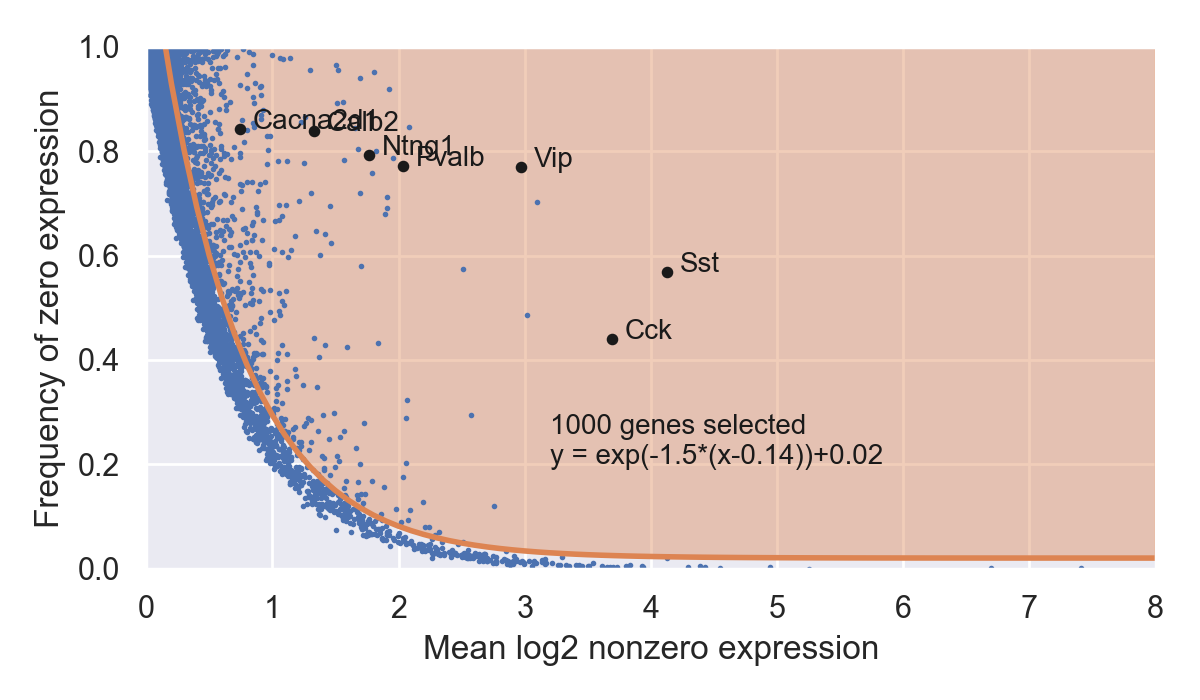

In [5]:
# Feature selection

importantGenes = rnaseqTools.geneSelection(
    harris['counts'], n=1000,
    genes = harris['genes'], 
    markers=['Sst', 'Pvalb', 'Cacna2d1', 'Calb2', 'Ntng1', 'Cck', 'Vip'])

# Library size normalization and log(x+1) transform

librarySizes = np.array(np.sum(harris['counts'], axis=1))
X = np.log2(harris['counts'][:, importantGenes] / librarySizes * np.median(librarySizes) + 1)  
X = np.array(X)

# PCA

X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

X = X / np.max(np.abs(X))

PCAinit = X[:,:2] / np.std(X[:,0]) * .0001

<IPython.core.display.Javascript object>


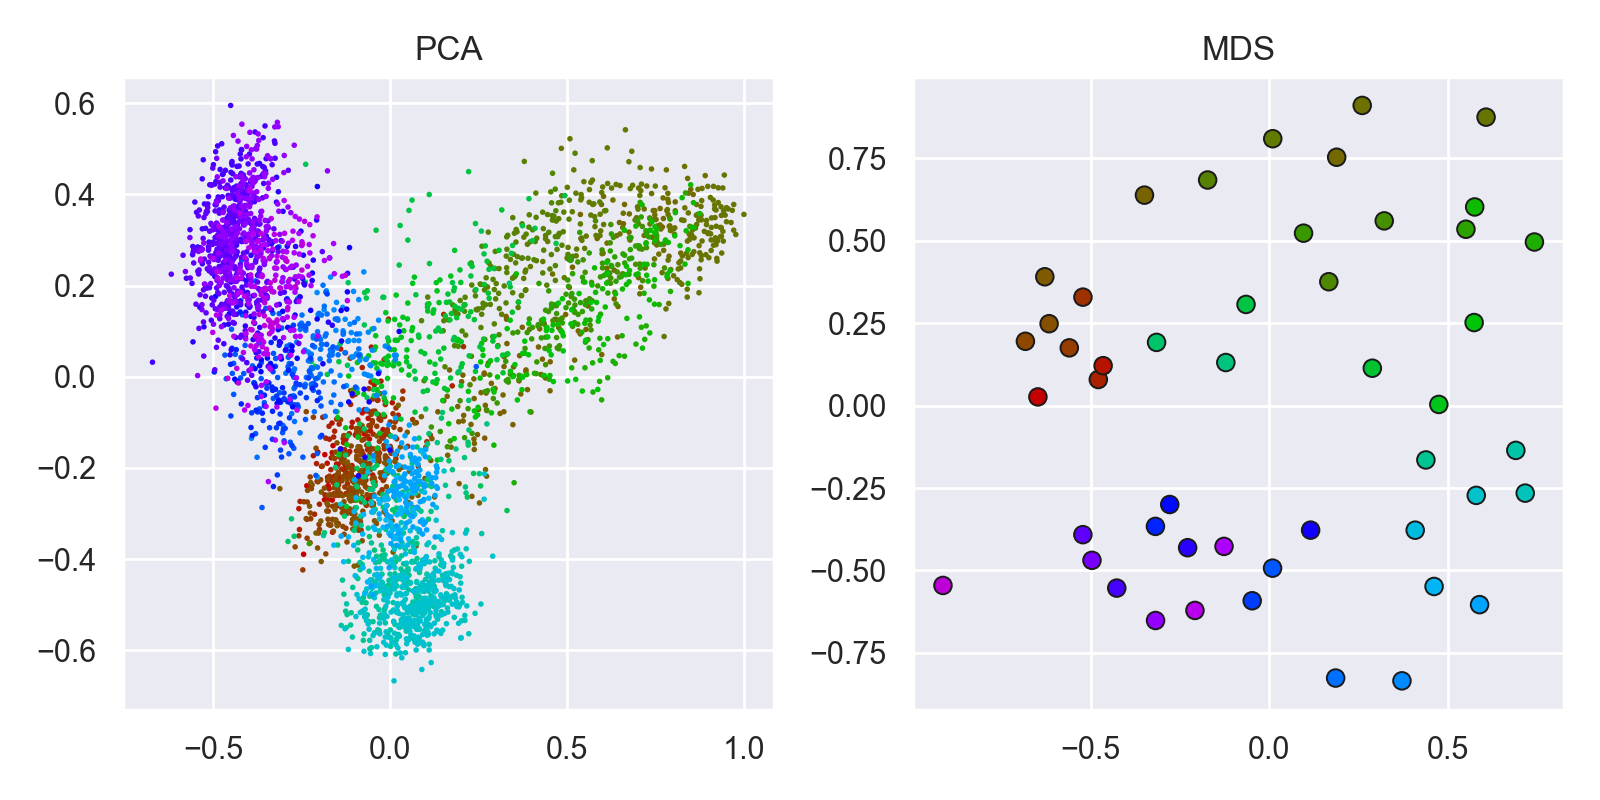

In [6]:
# PCA and MDS

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], s=1, c=harris['clusterColors'][harris['clusters']])
plt.title('PCA')

K = harris['clusterNames'].size
Zmeans = np.zeros((K, 50))
for c in range(K):
    Zmeans[c,:] = np.mean(X[harris['clusters']==c, :], axis=0)

from sklearn.manifold import MDS
embedding = MDS(n_components=2, n_init=500, random_state=42)
B = embedding.fit_transform(Zmeans)
cryabCluster = np.where(harris['clusterNames']=='Sst.Cryab')[0]
B[cryabCluster,:] = np.nan

plt.subplot(122)
plt.scatter(B[:,0], B[:,1], color=harris['clusterColors'],
            s=40, edgecolor='k', linewidth=.7);
plt.title('MDS')
plt.tight_layout()

=============== t-SNE v1.2.1 ===============
fast_tsne data_path: data_2022-05-16 08:57:36.744094-103295108.dat
fast_tsne result_path: result_2022-05-16 08:57:36.744094-103295108.dat
fast_tsne nthreads: 8
Read the following parameters:
	 n 3663 by d 50 dataset, theta 0.500000,
	 perplexity 30.000000, no_dims 2, max_iter 750,
	 stop_lying_iter 250, mom_switch_iter 250,
	 momentum 0.500000, final_momentum 0.800000,
	 learning_rate 305.250000, max_step_norm 5.000000,
	 K -1, sigma -1.000000, nbody_algo 2,
	 knn_algo 1, early_exag_coeff 12.000000,
	 no_momentum_during_exag 0, n_trees 50, search_k 4500,
	 start_late_exag_iter -1, late_exag_coeff -1.000000
	 nterms 3, interval_per_integer 1.000000, min_num_intervals 50, t-dist df 1.000000
Read the 3663 x 50 data matrix successfully. X[0,0] = -0.206252
Read the initialization successfully.
Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problems)
Usi

<IPython.core.display.Javascript object>


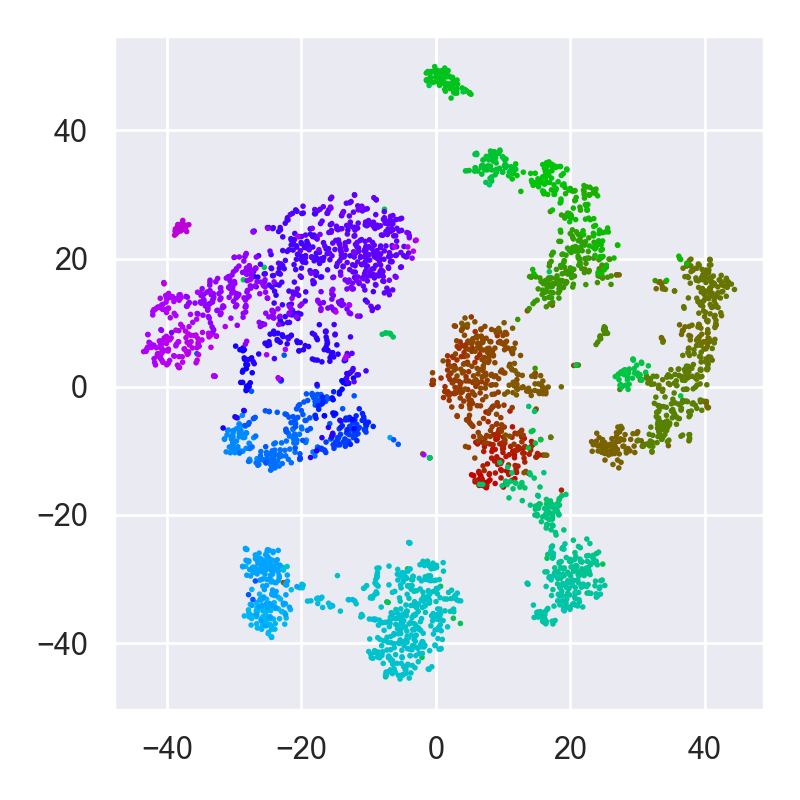

(0.45247065247065243, 0.736734693877551, 0.5959726285015654)
(0.4556920556920557, 0.7306122448979592, 0.5787431193284543)


In [7]:
# t-SNE

Z_harris_default = fast_tsne(X, perplexity=30, seed=42)
Z_harris = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)],
                     initialization=PCAinit, learning_rate = X.shape[0]/12)

plt.figure(figsize=(4,4))
plt.scatter(Z_harris[:,0], Z_harris[:,1], s=1, c=harris['clusterColors'][harris['clusters']])
plt.tight_layout()

harris_quality = embedding_quality(X, Z_harris, harris['clusters'])
harris_quality_default = embedding_quality(X, Z_harris_default, harris['clusters'])

print(harris_quality)
print(harris_quality_default)

In [9]:
import umap 

In [10]:
%%time
Z_harris2 = umap.UMAP(random_state=1, min_dist=.5, n_neighbors=30).fit_transform(X)

In [12]:
harris_umap_quality = embedding_quality(X, Z_harris2, harris['clusters'])
harris_umap_quality

(0.2828009828009828, 0.7489795918367347, 0.5232376052613847)

In [14]:
harris_pca_quality = embedding_quality(X, X[:,:2], harris['clusters'])
harris_pca_quality

(0.07286377286377287, 0.6693877551020408, 0.6843430349208668)